In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값
# one hot encoding
cols = ["pclass","sex","embarked"] # 범주형
enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
features = pd.concat([features,tmp],axis=1)
# 나이 결측치 채우기
features.age = features.age.fillna(features.age.median())

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [3]:
SEED = 42

In [4]:
x_train,x_valid,y_train,y_valid = train_test_split(features,target,random_state=SEED,test_size=0.2)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((712, 13), (179, 13), (712,), (179,))

# Model Tuning(Hyperparameter Optimization)
- 학습을 수행하기전에 설정해야하는 값인 하이퍼파라미터의 최적값을 탐색

## Grid Search
- 하이퍼파라미터별로 다양한 값들을 지정하여 모든 조합에 대해 성능 결과를 측정한 후 가장 높은 성능을 발휘했던 하이퍼파라미터 조합을 선정하는 방법

In [6]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True,random_state=SEED)

In [8]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

hp = {
    "max_depth" : range(2,5), # 깊이
    "min_samples_split" : range(2,5), # 내부노드를 분할하는데 필요한 최소 샘플수
    "criterion" : ["gini","entropy"], # 순수도 척도
    "max_leaf_nodes" : range(5,10), # 최대 리프 노드수
    "n_estimators" : range(50,100,10) # 부스팅 단계수
}
model = LGBMClassifier(random_state=SEED)
grid = GridSearchCV(
    model,
    hp,
    cv=cv,
    scoring = "roc_auc",
    n_jobs = -1
)
grid.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 5),
                         'max_leaf_nodes': range(5, 10),
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(50, 100, 10)},
             scoring='roc_auc')

In [9]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_leaf_nodes': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [10]:
grid.best_score_

0.8578552243327711

In [11]:
grid.score(x_valid,y_valid)

0.8893822393822393

In [13]:
pred = grid.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.8893822393822393

## Random Search
- 하이퍼파라미터 별로 다양한 값들을 지정하여 랜덤 조합을 통해 반복 수행하여 가장 높은 성능을 발휘했던 하이퍼파라미터 조합을 선정

In [14]:
from sklearn.model_selection import RandomizedSearchCV

hp = {
    "max_depth" : range(2,15), # 깊이
    "min_samples_split" : range(2,10), # 내부노드를 분할하는데 필요한 최소 샘플수
    "criterion" : ["gini","entropy"], # 순수도 척도
    "max_leaf_nodes" : range(5,10), # 최대 리프 노드수
    "n_estimators" : range(50,201,10) # 부스팅 단계수
}

model = LGBMClassifier(random_state=SEED)

rand = RandomizedSearchCV(
    model,
    hp,
    cv=cv,
    scoring = "roc_auc",
    n_jobs = -1,
    random_state=SEED,
    n_iter = 15
)
rand.fit(x_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(random_state=42), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 15),
                                        'max_leaf_nodes': range(5, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(50, 201, 10)},
                   random_state=42, scoring='roc_auc')

In [15]:
rand.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'max_leaf_nodes': 5,
 'max_depth': 2,
 'criterion': 'entropy'}

In [16]:
rand.best_score_

0.8534515351718867

In [17]:
rand.score(x_valid,y_valid)

0.890990990990991

In [18]:
model = LGBMClassifier(random_state=SEED, **rand.best_params_)
model.fit(x_train,y_train)

pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.890990990990991

## Grid Search vs Random Search
- Random Search 는 Grid Search에 비해 불필요한 반복 수행 횟수를 대폭 줄이면서 동시에 정해진 간격(Grid) 사이에 위치한 값들에 대해서도 확률적으로 탐색이 가능해서 최적의 하이퍼파라미터를 더 빨리 찾을수 있다.

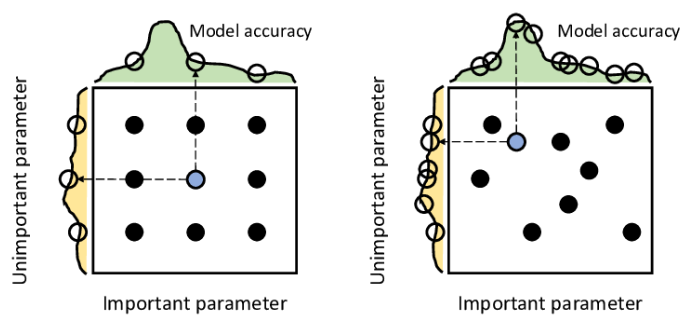

## 베이지안 최적화(Bayesian Optimization)
- 매회 새로운 하이퍼파라미터값에 대한 조사를 수행할 시 사전 지식을 충분히 반영하면서 동시에 전체적인 탐색 과정을 체계적으로 수행할수 있는 방법

- 대체모델이라는걸 이용해서 이전 하이퍼파라미터조합의 적용결과를 기반으로 더 높은 성능점수를 얻는 하이퍼파라미터 조합을 예측하는 방식

In [19]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 61.7 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 112 kB 60.0 MB/s 
     |████████████████████████████████| 147 kB 57.2 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=38d61256e7a7272a38d10915ad0d2a5385dd777647ce8f437f34c1c46d26dbf2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [20]:
import optuna

- 목적함수 만들기

In [21]:
from sklearn.model_selection import cross_val_score

In [28]:
def objective(trial):
    hp = {
        "max_depth" : trial.suggest_int("max_depth",2,15),
        "min_samples_split" : trial.suggest_int("min_samples_split",2,10),
        "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
        "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
        "n_estimators" : trial.suggest_int("n_estimators",10,500),
        "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
    }
    cv = KFold(n_splits=5,shuffle=True,random_state=SEED)
    model = LGBMClassifier(random_state=SEED,**hp)
    scores = cross_val_score(model,x_train,y_train, cv = cv , scoring="roc_auc")
    return np.mean(scores)

In [29]:
sampler = optuna.samplers.TPESampler(seed=SEED) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)

study.optimize(objective,n_trials=50)

[I 2022-09-13 07:27:02,978] A new study created in memory with name: no-name-50c3054a-8acc-45eb-a199-536f17a7676e
[I 2022-09-13 07:27:03,179] Trial 0 finished with value: 0.8522732281153486 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'criterion': 'gini', 'max_leaf_nodes': 5, 'n_estimators': 86, 'learning_rate': 0.015227525095137952}. Best is trial 0 with value: 0.8522732281153486.
[I 2022-09-13 07:27:04,048] Trial 1 finished with value: 0.842336280687235 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'criterion': 'gini', 'max_leaf_nodes': 10, 'n_estimators': 418, 'learning_rate': 0.029110519961044856}. Best is trial 0 with value: 0.8522732281153486.
[I 2022-09-13 07:27:04,234] Trial 2 finished with value: 0.847517887036954 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'max_leaf_nodes': 7, 'n_estimators': 152, 'learning_rate': 0.06506676052501416}. Best is trial 0 with value: 0.8522732281153486.
[I 2022-09-13 07:27:04,371] Tria

In [30]:
print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

Best Score: 0.8612226995693584
Best hp {'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'max_leaf_nodes': 10, 'n_estimators': 81, 'learning_rate': 0.04761586218744837}


- 제 스타일

In [31]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        self.cv = KFold(n_splits=5,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",2,15),
            "min_samples_split" : trial.suggest_int("min_samples_split",2,10),
            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
            "n_estimators" : trial.suggest_int("n_estimators",10,500),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        cv = KFold(n_splits=5,shuffle=True,random_state=self.seed)
        model = LGBMClassifier(random_state=self.seed,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

In [32]:
sampler = optuna.samplers.TPESampler(seed=SEED) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(x_train,y_train,SEED)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

[I 2022-09-13 07:36:51,830] A new study created in memory with name: no-name-13177e6c-c407-4138-90c8-3f14cda18b2e
[I 2022-09-13 07:36:52,038] Trial 0 finished with value: 0.8522732281153486 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'criterion': 'gini', 'max_leaf_nodes': 5, 'n_estimators': 86, 'learning_rate': 0.015227525095137952}. Best is trial 0 with value: 0.8522732281153486.
[I 2022-09-13 07:36:52,848] Trial 1 finished with value: 0.842336280687235 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'criterion': 'gini', 'max_leaf_nodes': 10, 'n_estimators': 418, 'learning_rate': 0.029110519961044856}. Best is trial 0 with value: 0.8522732281153486.
[I 2022-09-13 07:36:53,057] Trial 2 finished with value: 0.847517887036954 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'max_leaf_nodes': 7, 'n_estimators': 152, 'learning_rate': 0.06506676052501416}. Best is trial 0 with value: 0.8522732281153486.
[I 2022-09-13 07:36:53,192] Tria

Best Score: 0.8612226995693584
Best hp {'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'max_leaf_nodes': 10, 'n_estimators': 81, 'learning_rate': 0.04761586218744837}


In [33]:
study.best_params

{'max_depth': 2,
 'min_samples_split': 2,
 'criterion': 'entropy',
 'max_leaf_nodes': 10,
 'n_estimators': 81,
 'learning_rate': 0.04761586218744837}

- 검증셋 점수 확인

In [34]:
model = LGBMClassifier(random_state=SEED, **study.best_params)
model.fit(x_train,y_train)

pred = model.predict_proba(x_valid)[:,1]

roc_auc_score(y_valid,pred)

0.8868725868725869

- 하이퍼파라미터 중요도 시각화

In [36]:
optuna.visualization.plot_param_importances(study)

- 하이퍼파라미터 최적화 과정 history

In [37]:
optuna.visualization.plot_optimization_history(study)

- https://optuna.readthedocs.io/en/stable/index.html